In [1]:
import pandas as pd
import matplotlib.pyplot as plt


path = "/home/carlo/bristoluni/Applied Data Science/git-master/Data/"
filename = path + "water_quality.csv"

In [2]:
# further process of the data frame
def split_on_variables_then_merge_data_frames_on_keys(frame, keys, var1, var2):
    selected_rows = frame[(frame['determinand.label'] == var1) | (frame['determinand.label'] == var2)]
    left_frame = selected_rows[selected_rows['determinand.label'] == var1]
    right_frame = selected_rows[selected_rows['determinand.label'] == var2]
    merged = pd.merge(left_frame, right_frame, on=keys)
    return merged

In [3]:
data = pd.read_csv(filename)
df = data[['determinand.label', 'result', 'determinand.unit.label', 'water body']]

grouped = df.groupby(['determinand.label', 'determinand.unit.label'])['result'].agg([pd.np.min, pd.np.max, pd.np.mean, pd.np.std, 'count'])
filtered = grouped[grouped['count'] > 15]
#del filtered['count']

In [4]:
filtered

,,amin,amax,mean,std,count
determinand.label,determinand.unit.label,,,,,
Alky pH 4.5,mg/l,171.00000,326.0000,234.973684,32.325613,38
Ammonia(N),mg/l,0.03000,9.1700,0.577450,1.457473,60
B-[a]-pyrene,ug/l,0.00017,0.0229,0.002287,0.005085,20
B-[b]-fluora,ug/l,0.00037,0.0241,0.002732,0.005269,20
B-[ghi]-pery,ug/l,0.00036,0.0313,0.003066,0.006888,20
B-[k]-fluora,ug/l,0.00011,0.0111,0.001155,0.002443,20
BOD ATU,mg/l,8.00000,464.0000,92.280000,164.836414,25
COD as O2,mg/l,52.00000,1255.0000,394.625000,496.830068,16
Cond @ 25C,us/cm,538.00000,2557.0000,903.552632,403.940302,38


In [5]:
# find correlation between variables
variable1 = 'Ammonia(N)'
variable2 = 'N Oxidised'

In [6]:
# process data frame, select columns of interest.
# create a left and right data frame (to separate the variables) and then do an inner join
# on the water body and date.
# (i.e. pick the measurements that were taken at the same time and place)
df2 = data[['determinand.label', 'result', 'determinand.unit.label', 'sample.sampleDateTime', 'Waterbody ID']]
merged_df = split_on_variables_then_merge_data_frames_on_keys(frame=df2, keys=['Waterbody ID', 'sample.sampleDateTime'], var1=variable1, var2=variable2)

# get the ingredients to produce the plot
x, y = merged_df['result_x'], merged_df['result_y']
var_x, var_y = merged_df['determinand.label_x'][0], merged_df['determinand.label_y'][0]
unit_measure_x, unit_measure_y = merged_df['determinand.unit.label_x'][0], merged_df['determinand.unit.label_y'][0]

In [7]:
# TO DO
# 1. fit curve/ polynomial and display it in the graph (we may try different degrees)
# 2. report squared error
# 3. if the relation is linear, computer Pearson index coefficient. Otherwise, I don't know
# 4. talk about the relation

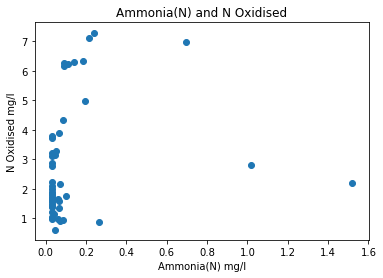

In [8]:
plt.scatter(x, y)
plt.xlabel(var_x + ' ' + unit_measure_x)
plt.ylabel(var_y + ' ' + unit_measure_y)
plt.title(var_x + ' and ' + var_y)
plt.show()